In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [6]:
dataset = "/kaggle/input/dataset-caps/Dataset_caps"

In [7]:
class_names = os.listdir(dataset)

for class_name in class_names:
    class_dir = os.path.join(dataset, class_name)
    num_images = len(os.listdir(class_dir))
    print("Class {}: {} images".format(class_name, num_images))

Class 5. Melanocytic Nevi (NV) : 100 images
Class 8. Seborrheic Keratoses and other Benign Tumors: 100 images
Class 4. Basal Cell Carcinoma (BCC: 100 images
Class 2. Melanoma: 100 images
Class 3. Atopic Dermatitis: 100 images
Class 1. Eczema: 100 images
Class 6. vitiligo: 100 images
Class 10. Warts Molluscum and other Viral Infections: 100 images
Class 9. Tinea Ringworm Candidiasis and other Fungal Infections : 100 images
Class 7. Psoriasis pictures Lichen Planus and related diseases: 100 images


In [11]:
data = {"class_names": class_names}
df = pd.DataFrame(data)

In [12]:
df

,class_names
0,5. Melanocytic Nevi (NV)
1,8. Seborrheic Keratoses and other Benign Tumors
2,4. Basal Cell Carcinoma (BCC
3,2. Melanoma
4,3. Atopic Dermatitis
5,1. Eczema
6,6. vitiligo
7,10. Warts Molluscum and other Viral Infections
8,9. Tinea Ringworm Candidiasis and other Fungal...
9,7. Psoriasis pictures Lichen Planus and relate...


<Axes: xlabel='class_names'>

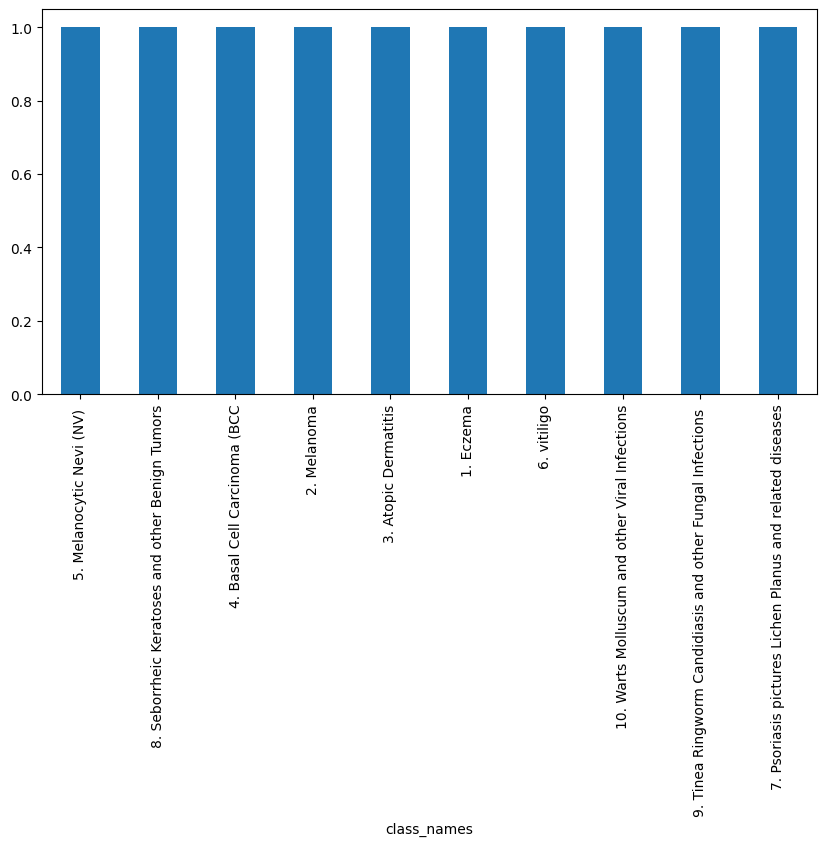

In [14]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['class_names'].value_counts().plot(kind='bar', ax=ax1)

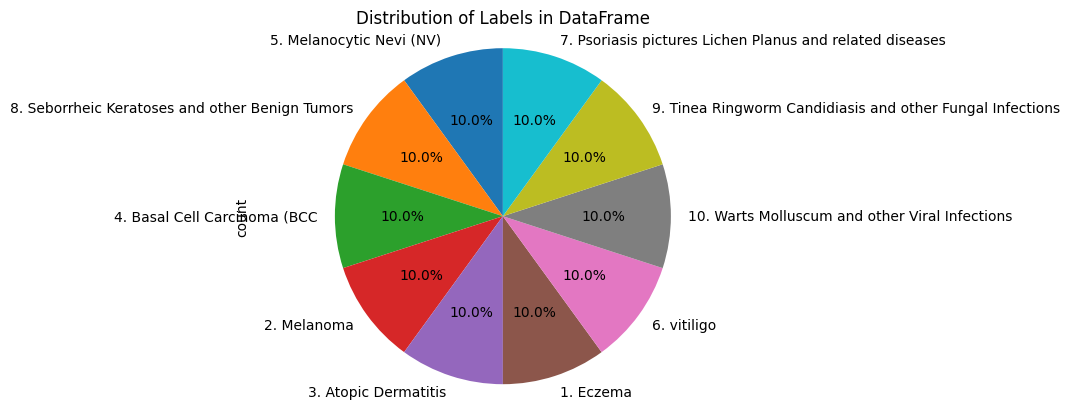

In [17]:
df['class_names'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.show()

In [18]:
import concurrent.futures
import tensorflow as tf


gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[]


In [19]:
import multiprocessing

max_workers = multiprocessing.cpu_count()
max_workers

4

In [26]:
import random
import cv2

train_data = []
val_data = []

for folder in os.listdir(dataset):
    folder_path = os.path.join(dataset, folder)
    file = os.listdir(folder_path)
    num_train = int(0.8 * len(file))
    files_train = random.sample(file, num_train)
    files_val = list(set(file) - set(files_train))
    
    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        train_data.append((img, folder))
        
    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        val_data.append((img, folder))

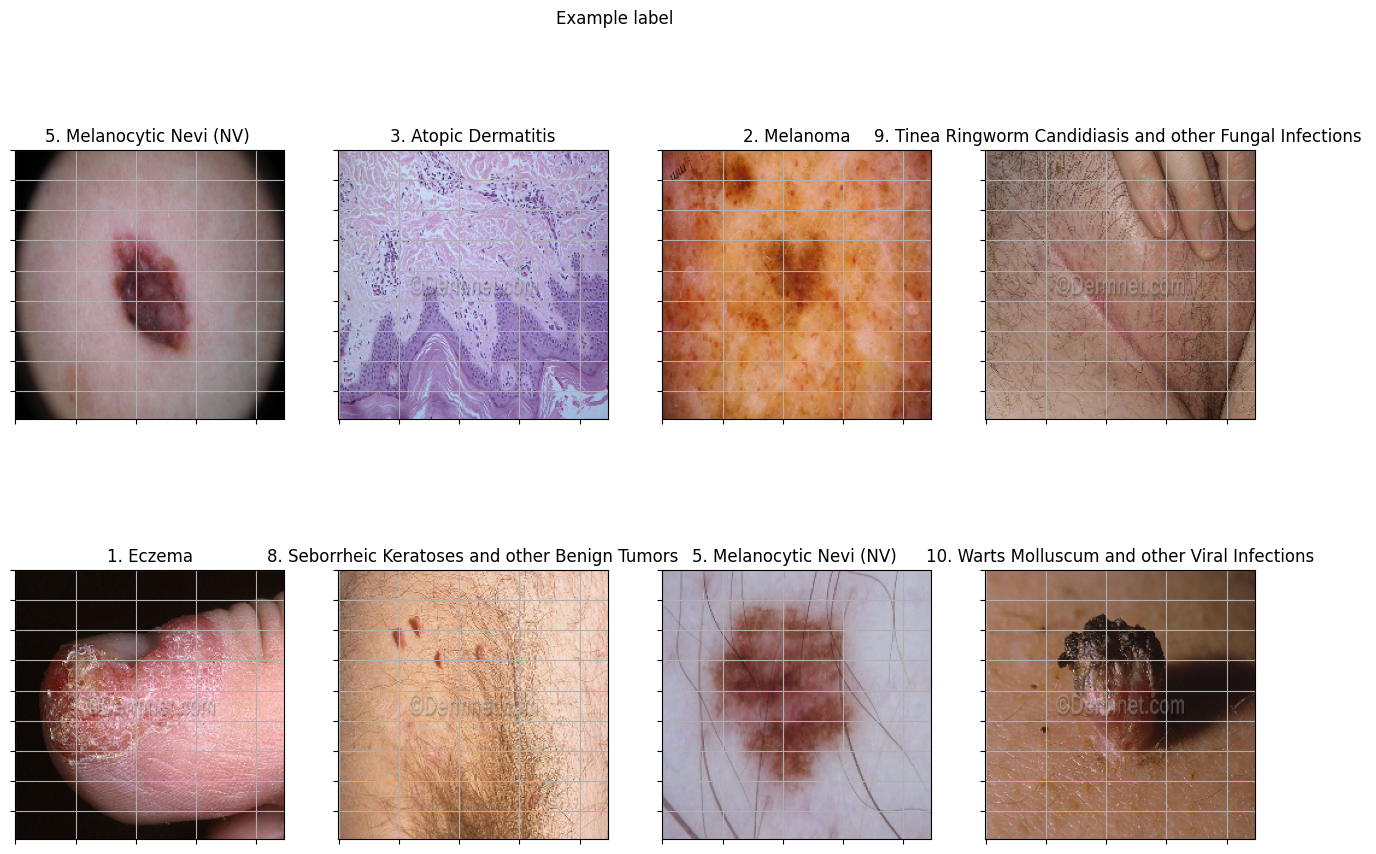

In [39]:
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
plt.suptitle('Example label')

for (img, label), ax in zip(random.sample(train_data, 8), axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )

plt.show()

In [40]:
from tensorflow.keras.applications import ResNet50
import os

local_weights_path = '/kaggle/input/resnet50-me/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

if not os.path.exists(local_weights_path):
    raise FileNotFoundError(f"The weights file was not found at {local_weights_path}")

base_model = ResNet50(weights=local_weights_path, include_top=False, input_shape=(224, 224, 3))

In [41]:
base_model.trainable = False

In [43]:
from tensorflow.keras.layers import GlobalAveragePooling2D
num_classes = 10
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [46]:
from tensorflow.keras.models import Model
optimizer = Adam(learning_rate=0.0001)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [48]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

X_train = preprocess_input(np.array(X_train))
X_val = preprocess_input(np.array(X_val))

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes)

In [50]:
EPOCHS = 50
BATCH_SIZE = 32
history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                   epochs = EPOCHS, batch_size=BATCH_SIZE)

model.save('/kaggle/working/my_resnet_fork.h5')

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.3136 - loss: 2.1267 - val_accuracy: 0.4800 - val_loss: 1.5655
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.5354 - loss: 1.3462 - val_accuracy: 0.5550 - val_loss: 1.3259
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.6272 - loss: 1.0665 - val_accuracy: 0.6200 - val_loss: 1.2217
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.6795 - loss: 0.9604 - val_accuracy: 0.6400 - val_loss: 1.1212
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.7360 - loss: 0.8272 - val_accuracy: 0.6400 - val_loss: 1.0605
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.7951 - loss: 0.6824 - val_accuracy: 0.6600 - val_loss: 1.0144
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.8362 - loss: 0.5836 - val_accuracy: 0.6550 - val_loss: 0.9826
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.8352 - loss: 0.5184 - val_accuracy: 0.6500 - val_loss:

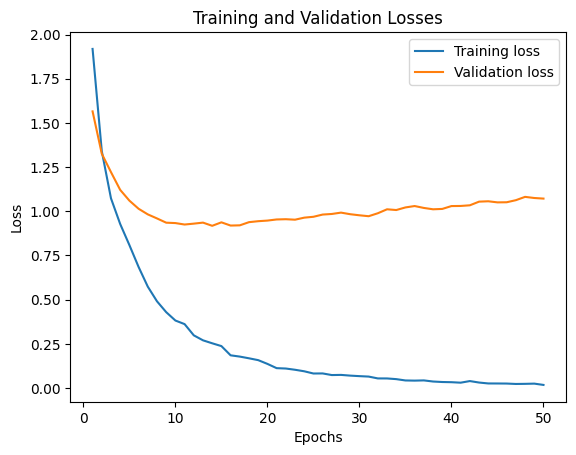

In [51]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss,label='Training loss')
plt.plot(epochs, val_loss,label='Validation loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

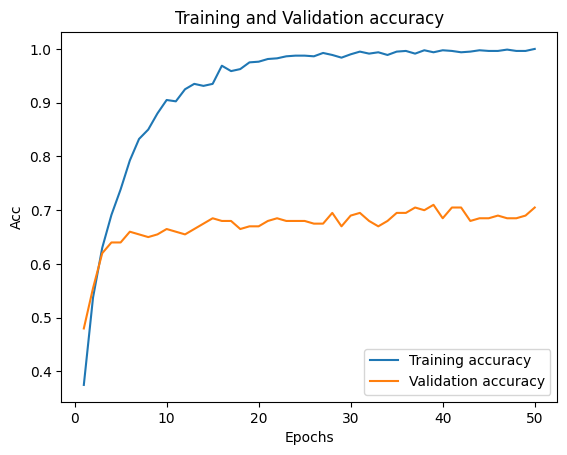

In [52]:
train_loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss,label='Training accuracy')
plt.plot(epochs, val_loss,label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()


plt.show()

In [53]:
model.save('resnet_model1.h5')

In [54]:
from keras.models import load_model
from keras.optimizers import Adam  


model = load_model('resnet_model1.h5')


optimizer = 'adam'
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


EPOCHS = 10
BATCH_SIZE = 32


history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                    epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9484 - loss: 0.1737 - val_accuracy: 0.6400 - val_loss: 1.4093
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.9002 - loss: 0.3366 - val_accuracy: 0.6450 - val_loss: 1.4333
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.9315 - loss: 0.2035 - val_accuracy: 0.6250 - val_loss: 1.4444
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.9390 - loss: 0.1858 - val_accuracy: 0.6300 - val_loss: 1.6518
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.9637 - loss: 0.1186 - val_accuracy: 0.6450 - val_loss: 1.6404
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.9729 - loss: 0.1264 - val_accuracy: 0.6450 - val_loss: 1.9267
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.9629 - loss: 0.1304 - val_accuracy: 0.6400 - val_loss: 1.9926
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.9549 - loss: 0.1429 - val_accuracy: 0.6400 - val_loss:

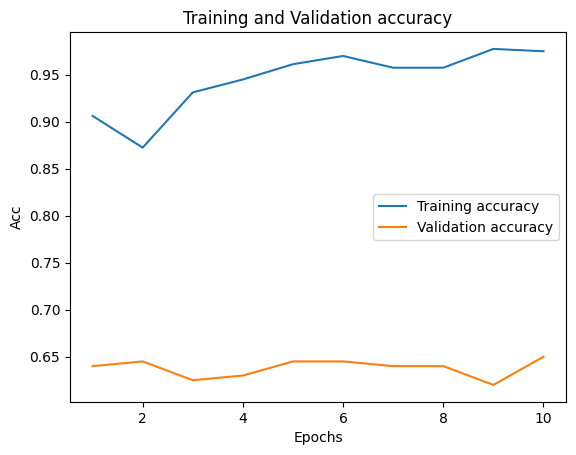

In [55]:
train_loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss,label='Training accuracy')
plt.plot(epochs, val_loss,label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()


plt.show()

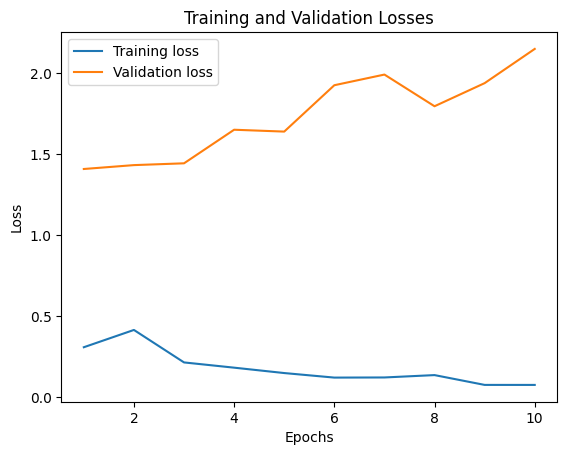

In [56]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss,label='Training loss')
plt.plot(epochs, val_loss,label='Validation loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()